In [159]:
import os
import folium
from folium.features import GeoJson, GeoJsonTooltip
import numpy as np
from pymongo import MongoClient
import json
import requests
from branca.colormap import linear
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('seaborn-white')
import geopandas as gpd
import fiona
#matplotlib inline

print(folium.__version__)

0.10.1


In [160]:
# read in needed enviornment variables
DBUSER = os.environ["CSTATS_DATABASE_USER"]
DBPWD = os.environ["CSTATS_DATABASE_PWD"]
DBSVR = os.environ["CSTATS_DATABASE_SERVER"]

# build the connection string
DBCONNSTR = "mongodb+srv://{0}:{1}@{2}/test".format(DBUSER, DBPWD, DBSVR)

client = MongoClient(DBCONNSTR)
db = client.closet_stats

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

FILE_STUB = 'counties_2020'
FILE_STUB2 = 'zips_2020'
# let's get, and cache, the data from the data store
# this is also where we can adjust our filter
start = datetime(2020, 1, 1, 0, 0, 0)
end = datetime(2021, 1, 1, 0, 0, 0)
#visitdata = db.visits.find({'timestamp': {'$lt': end, '$gte': start}})
visits = pd.DataFrame(list(db.visits.find({'timestamp': {'$lt': end, '$gte': start}})))

# should we persist to disk for offline access?


# 2020 Statistics

In [161]:
def served_by_county_map_data(db, file_stub='countydata'):
    counties = {}

    for index, row in visits.iterrows():
        county = row['county'] if not pd.isnull(row['county']) else None
        if county:
            if county in counties:
                counties[county] += row["numKidsServed"]
            else:
                counties[county] = row["numKidsServed"]

    # now, let's loop through the counties, set up some structure and dump
    county_data = []
    for k in counties.keys():
        county_data.append({
            "name": k,
            "numkids": counties[k]
        })

    with open(file_stub+'.json', 'w', encoding='utf-8') as f:
        json.dump(county_data, f, ensure_ascii=False, indent=5)
    

def color_from_cmap(cmap, county, mydict):
    count = mydict.get(county, 0)
    if count == 0:
        return "#d9d9d9"
    else:
        return cmap(count)

In [162]:
def served_by_county_map(db, file_stub, start=None, end=None):
    served_by_county_map_data(db,file_stub=file_stub)

    df = pd.read_json(file_stub+'.json')
    county_dict = df.set_index('name')['numkids']

    # create a colormap based on the data
    colormap = linear.Blues_09.scale(
        df.numkids.min(),
        df.numkids.max())

    with open("tncounties.json") as f:
        geo_json_data = json.load(f)

    # create the map itself
    m = folium.Map(location=[35.9586581,-84.0655071], tiles='stamentoner', zoom_start=8)

    # markers for our two locations
    #folium.Marker([35.888723,-84.1502008], popup='<b>West Knoxville</b>').add_to(m)
    #folium.Marker([36.0396383,-84.220025], popup='<b>Oak Ridge</b>').add_to(m)
    folium.Marker([35.294231,-82.5641737], popup='holder').add_to(m)

    # create tooltips
    #tooltip=GeoJsonTooltip(
    #    fields=["name", "numkids"],
    #    aliases=["County:", "Children Served:"],
    #    localize=True,
    #    sticky=False,
    #    labels=True,
    #    style="""
    #        background-color: #F0EFEF;
    #        border: 2px solid black;
    #        border-radius: 3px;
    #        box-shadow: 3px;
    #    """,
    #)
    
    # add the geojson to the map
    folium.GeoJson(geo_json_data,
        style_function=lambda feature: {
            'fillColor': color_from_cmap(colormap, feature['id'], county_dict),
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9
        },
        #tooltip=tooltip
    ).add_to(m)

    # Add our caption/key
    colormap.caption = 'Kids Served'
    colormap.add_to(m)

    # save a file to disk
    m.save(os.path.join('results', file_stub+'.html'))

    return m

In [163]:
def county_map():

    # load the geojson into a fram
    with open("tncounties.json") as f:
        counties = gpd.GeoDataFrame.from_features(json.load(f))
        counties.crs = 'epsg:4326'

    # get the visit data by county
    result = visits.groupby(['county'])['numKidsServed'].aggregate(sum).reset_index()
    
    # merge the results with our county shapes
    countiesmerge = counties.merge(result,how='left', left_on='NAME', right_on='county')
    #countiesmerge['geometry']=countiesmerge.geometry.simplify(.05)

    # create a colormap based on the data
    colormap = linear.Blues_09.scale(result.numKidsServed.min(), result.numKidsServed.max())
    
    # create the map itself
    m = folium.Map(location=[35.9586581,-84.0655071], tiles='stamentoner', zoom_start=9)
    
    # this is useless, but helps the page render when exported to reveal.js
    folium.Marker([35.294231,-82.5641737], popup='holder').add_to(m)
    
    tooltip=GeoJsonTooltip(
        fields=["NAME", "numKidsServed"],
        aliases=["County:", "Children Served:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        #max_width=800,
    )
    
    # add the geojson to the map
    folium.GeoJson(countiesmerge,
        style_function=lambda x: {
            "fillColor": colormap(x["properties"]["numKidsServed"])
            if x["properties"]["numKidsServed"] is not None
            else "#d9d9d9",
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.9,
            "text": x['properties']['numKidsServed']
        },           
        tooltip=tooltip
    ).add_to(m)

    # Add our caption/key
    colormap.caption = 'Kids Served'
    colormap.add_to(m)

    # save a file to disk
    m.save(os.path.join('results', FILE_STUB+'.html'))

    return m



def zip_map():

    # load the geojson into a fram
    with open("tn_tennessee_zip_codes_geo.min.json") as f:
        zips = gpd.GeoDataFrame.from_features(json.load(f))
        zips.crs = 'epsg:4326'

    # get the visit data by county
    result = visits.groupby(['zipCode'])['numKidsServed'].aggregate(sum).reset_index()   
    #print(len(zips))
    
    # merge the results with our county shapes
    zipsmerge = zips.merge(result,how='left', left_on='ZCTA5CE10', right_on='zipCode')
    #countiesmerge['geometry']=countiesmerge.geometry.simplify(.05)

    # purge the majority of the shapes (keep only the ones for which we have values!)
    # if we don't do this, the map is crazy intense to draw
    zipsmerge = zipsmerge[zipsmerge.zipCode.notnull()]
    #print(len(zipsmerge))
    
    
    # create a colormap based on the data
    colormap = linear.Blues_09.scale(result.numKidsServed.min(), result.numKidsServed.max())
    
    # create the map itself
    m = folium.Map(location=[35.9586581,-84.0655071], tiles='stamentoner', zoom_start=9)
    
    # this is useless, but helps the page render when exported to reveal.js
    folium.Marker([35.294231,-82.5641737], popup='holder').add_to(m)
    
    tooltip=GeoJsonTooltip(
        fields=["ZCTA5CE10", "numKidsServed"],
        aliases=["Zip:", "Children Served:"],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 2px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
    )
    
    # add the geojson to the map
    folium.GeoJson(zipsmerge,
        style_function=lambda x: {
            "fillColor": colormap(x["properties"]["numKidsServed"])
            if x["properties"]["numKidsServed"] is not None
            else "#d9d9d9",
            "color": "black",
            "weight": 1,
            "fillOpacity": 0.9,
            "text": x['properties']['numKidsServed']
        },           
        tooltip=tooltip
    ).add_to(m)

    # Add our caption/key
    colormap.caption = 'Kids Served'
    colormap.add_to(m)

    # save a file to disk
    m.save(os.path.join('results', FILE_STUB2+'.html'))

    return m




In [164]:
total = visits['numKidsServed'].sum()
total

313

In [165]:
def total_served(split_loc=False):
    if split_loc:
        result = visits.groupby(['closetLocation']).aggregate({'numKidsServed': [len, sum]}).reset_index()
        g = sns.catplot(data=result, col='closetLocation', kind='bar', ci=None, palette="Blues_d")
        g.height = 9
        g.set_xticklabels(['Visits', 'Kids Served'])        
    else:
        fig, ax = plt.subplots(figsize=(15,9))
        labels = ['Visits', 'Served']
        values = []
        values.append(visits.numKidsServed.count())
        values.append(visits.numKidsServed.sum())
        g = sns.barplot(x=labels, y=values, ci=None, ax=ax, palette="Blues_d")
        g.height = 9
        g.set_xticklabels(['Visits', 'Kids Served'])        

In [166]:
def plot_visits_by_location():
    fig, ax = plt.subplots(figsize=(15,9))
    with sns.axes_style('white'):
        g = sns.barplot(x='closetLocation', y='numKidsServed', data=visits, estimator=len, ci=None, ax=ax)
        g.set_title("Visits by Location")
        g.set_ylabel('Visits')
        g.set_xlabel('Closet Location')

In [167]:
def served_by_month(split_loc=False):
    result = visits.groupby([pd.Grouper(key="timestamp", freq="M"), 'closetLocation'])["numKidsServed"].aggregate(sum).reset_index()

    fig, ax = plt.subplots(figsize=(15,9))
    with sns.axes_style('white'):
        if (split_loc):
            g = sns.barplot(x='timestamp', y='numKidsServed', hue='closetLocation', data=result, estimator=sum, 
                            ci=None, ax=ax)
        else:
            g = sns.barplot(x='timestamp', y='numKidsServed', data=result, estimator=sum, ci=None, ax=ax, 
                            palette="Blues_d")

        g.set_title("Children Served by Month")
        g.set_ylabel('Children Served')
        g.set_xlabel('Month')
        g.set_xticklabels(MONTHS)

In [168]:
def served_by_zip(split_loc=False):
    fig, ax = plt.subplots(figsize=(15,9))
    #result = visits.groupby(["zipCode"])['numKidsServed'].aggregate(sum).reset_index().sort_values('numKidsServed', ascending=False)
    result = visits.groupby(["zipCode"])['numKidsServed'].aggregate(sum).reset_index().sort_values('zipCode')
    with sns.axes_style('white'):
        if split_loc:
            g = sns.barplot(x='zipCode', y='numKidsServed', hue='closetLocation', data=visits, estimator=sum, 
                            ci=None, ax=ax, order=result['zipCode'])
        else:
            g = sns.barplot(x='zipCode', y='numKidsServed', data=visits, estimator=sum, ci=None, ax=ax, 
                            order=result['zipCode'], palette="Blues_d")
        g.set_title("Children Served by Zip Code")
        g.set_ylabel('Children Served')
        g.set_xlabel('Zip Code')
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
        
def served_by_county(split_loc=False):
    fig, ax = plt.subplots(figsize=(15,9))
    #result = visits.groupby(["zipCode"])['numKidsServed'].aggregate(sum).reset_index().sort_values('numKidsServed', ascending=False)
    result = visits.groupby(["county"])['numKidsServed'].aggregate(sum).reset_index().sort_values('county')
    with sns.axes_style('white'):
        if split_loc:
            g = sns.barplot(x='county', y='numKidsServed', hue='closetLocation', data=visits, estimator=sum, 
                            ci=None, ax=ax, order=result['county'])
        else:
            g = sns.barplot(x='county', y='numKidsServed', data=visits, estimator=sum, ci=None, ax=ax, 
                            order=result['county'], palette="Blues_d")
        g.set_title("Children Served by County")
        g.set_ylabel('Children Served')
        g.set_xlabel('County')
        g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [169]:
def served_by_agency(split_loc=False):
    fig, ax = plt.subplots(figsize=(15,9))
    result = visits.groupby(["agencyConnection"])['numKidsServed'].aggregate(sum).reset_index().sort_values('numKidsServed', ascending=False)
    with sns.axes_style('white'):
        if split_loc:
            g = sns.barplot(x='agencyConnection', y='numKidsServed', hue='closetLocation', data=visits, 
                            estimator=sum, ci=None, ax=ax, order=result['agencyConnection'])
        else:
            g = sns.barplot(x='agencyConnection', y='numKidsServed', data=visits, estimator=sum, ci=None, 
                            ax=ax, order=result['agencyConnection'], palette="Blues_d")
        g.set_title("Children Served by Agency/Connection")
        g.set_ylabel('Children Served')
        g.set_xlabel('Agency/Connection')
        g.set_xticklabels(g.get_xticklabels(), rotation=30)

        
def served_by_gender():
    fig, ax = plt.subplots(figsize=(15,9))
    
    # get our list of girls/boys
    result = visits[{'numGirlsServed', 'numBoysServed'}].aggregate(sum)

    with sns.axes_style('white'):
        g = sns.barplot(x=['Girls', 'Boys'], y=[result['numGirlsServed'], result['numBoysServed']], ci=None,
                        ax=ax, palette="Blues_d")
        g.set_title("Children Served by Gender")
        g.set_ylabel('Children Served')
        
        
def served_by_age():
    fig, ax = plt.subplots(figsize=(15,9))
    age_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18+']
    age_fields = ['childrenAges0', 'childrenAges1', 'childrenAges2', 'childrenAges3', 'childrenAges4',
                  'childrenAges5', 'childrenAges6', 'childrenAges7', 'childrenAges8', 'childrenAges9',
                  'childrenAges10', 'childrenAges11', 'childrenAges12', 'childrenAges13', 'childrenAges14',
                  'childrenAges15', 'childrenAges16', 'childrenAges17', 'childrenAges18']
    result = visits[age_fields].aggregate(sum)

    with sns.axes_style('white'):
        g = sns.barplot(x=age_names, y=result.values, ci=None, ax=ax, palette="Blues_d")
        g.set_title("Children Served by Age")
        g.set_ylabel('Children Served')
        g.set_xlabel('Age')

## Summary

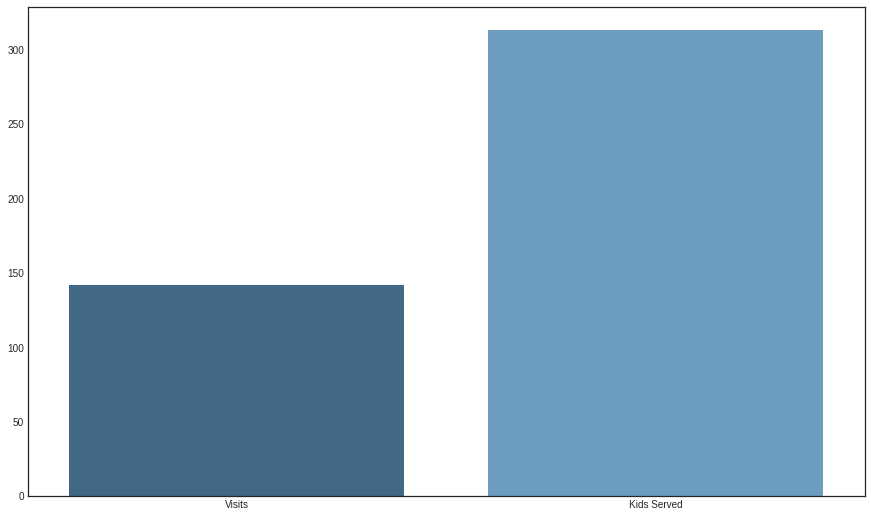

In [170]:
total_served()

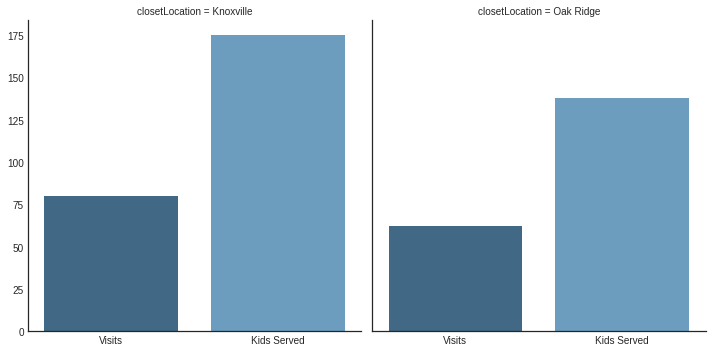

In [171]:
total_served(split_loc=True)

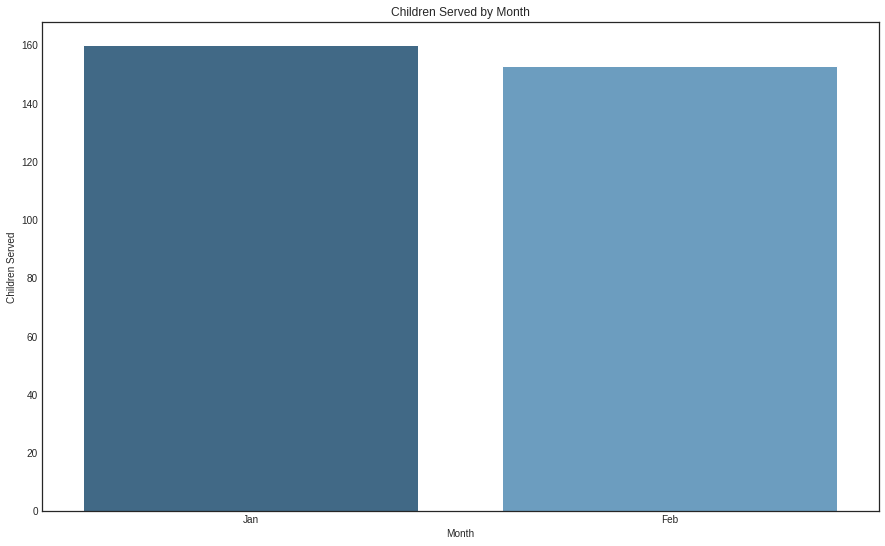

In [172]:
served_by_month()

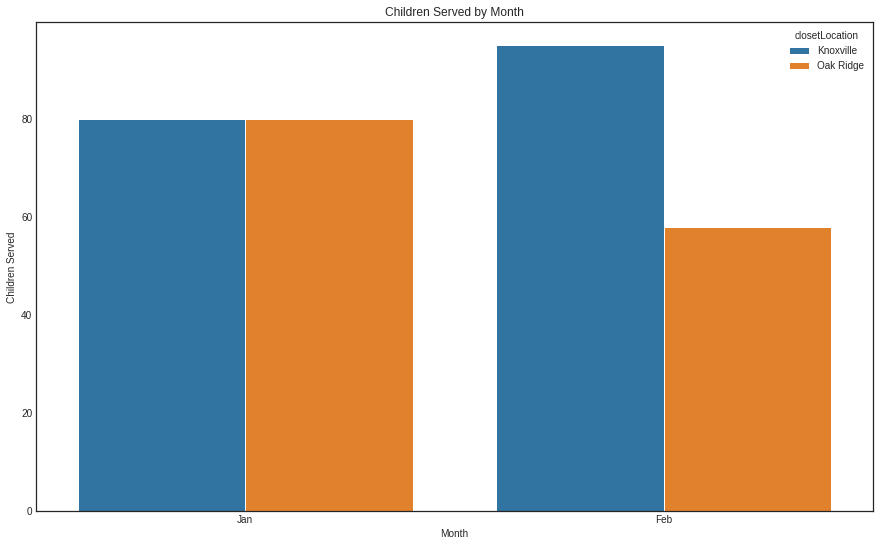

In [173]:
served_by_month(split_loc=True)

## Geographic: By County

In [174]:
m = county_map()
m

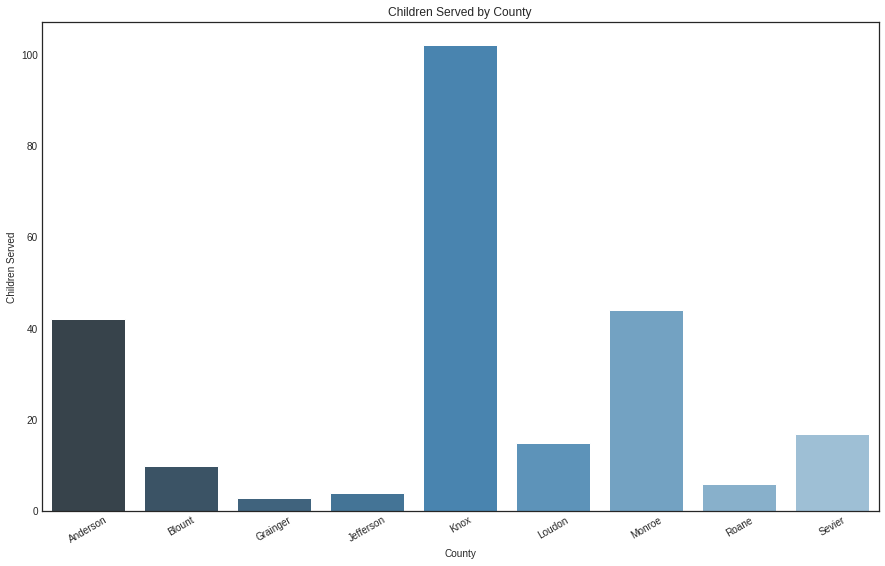

In [175]:
served_by_county()

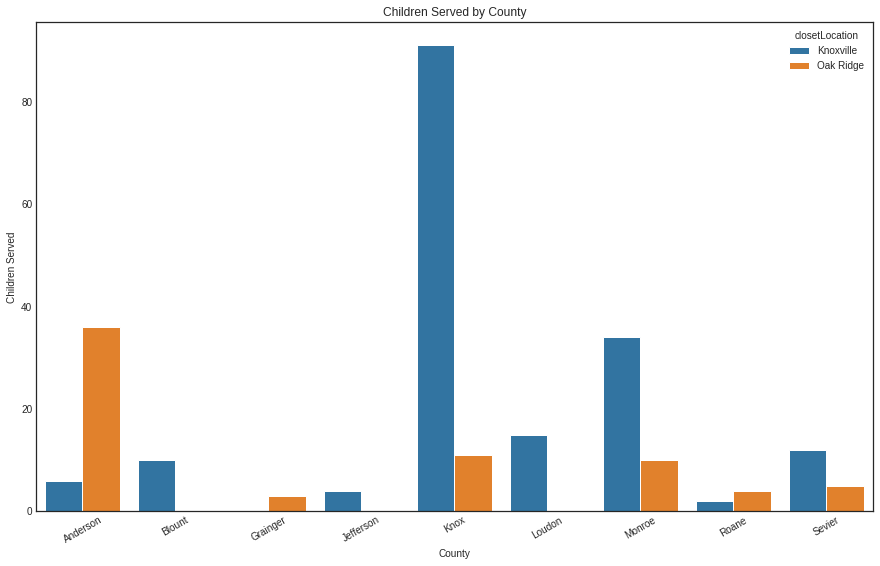

In [176]:
served_by_county(split_loc=True)

## Geographic: By Zip

In [177]:
m = zip_map()
m

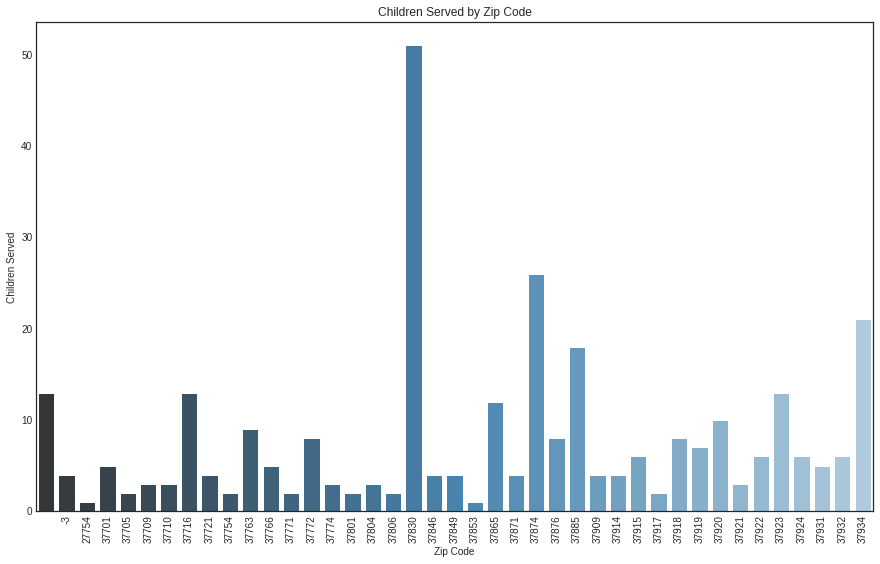

In [178]:
served_by_zip()

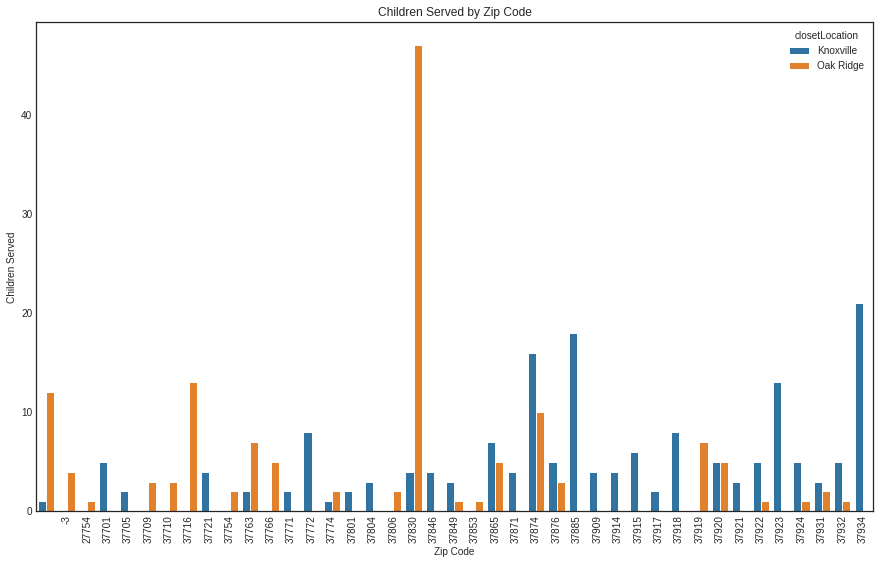

In [179]:
served_by_zip(split_loc=True)

## Agency/Connection

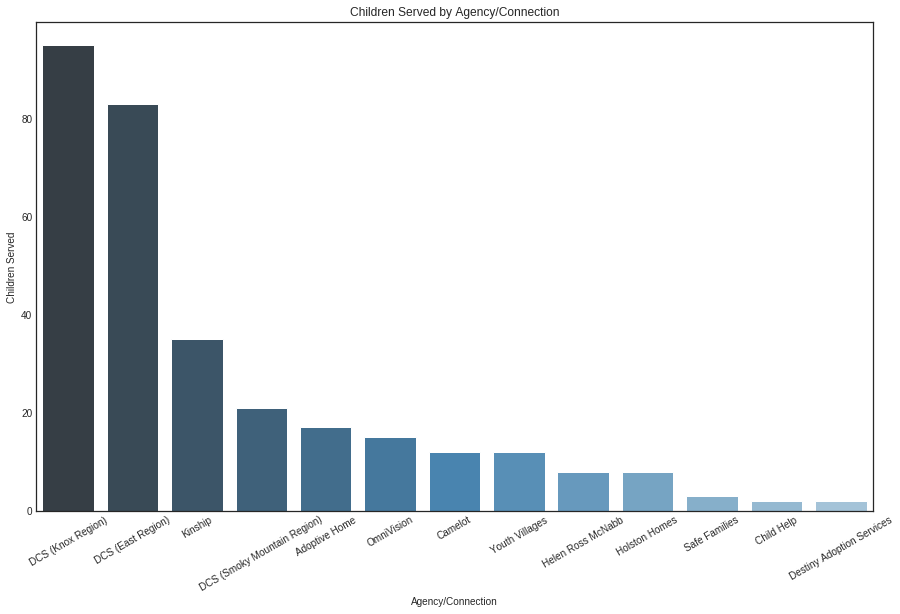

In [180]:
served_by_agency()

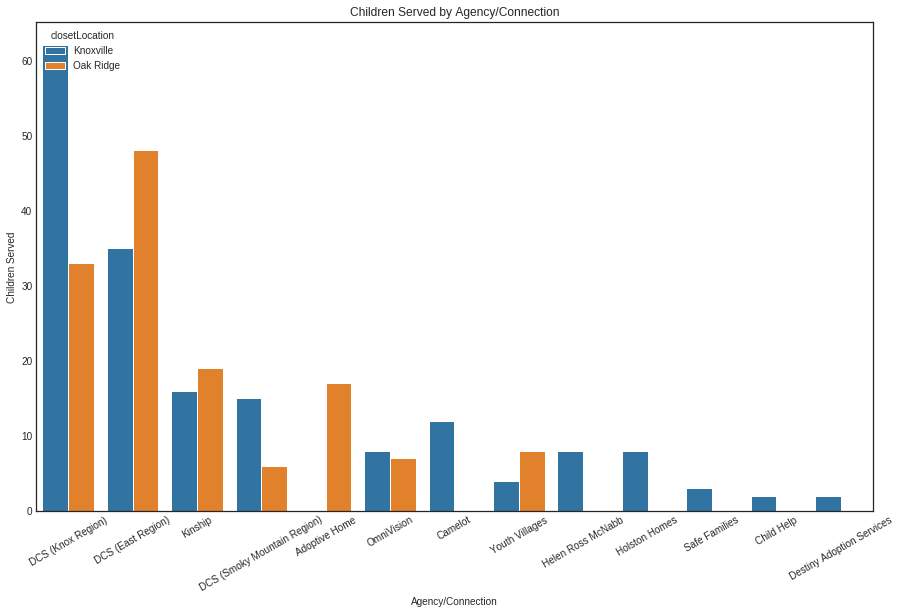

In [181]:
served_by_agency(split_loc=True)

## Miscellaneous

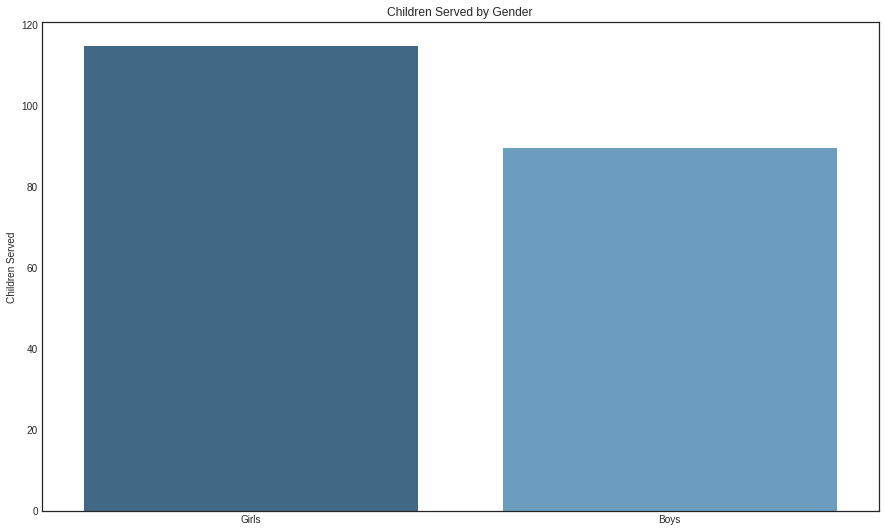

In [182]:
served_by_gender()

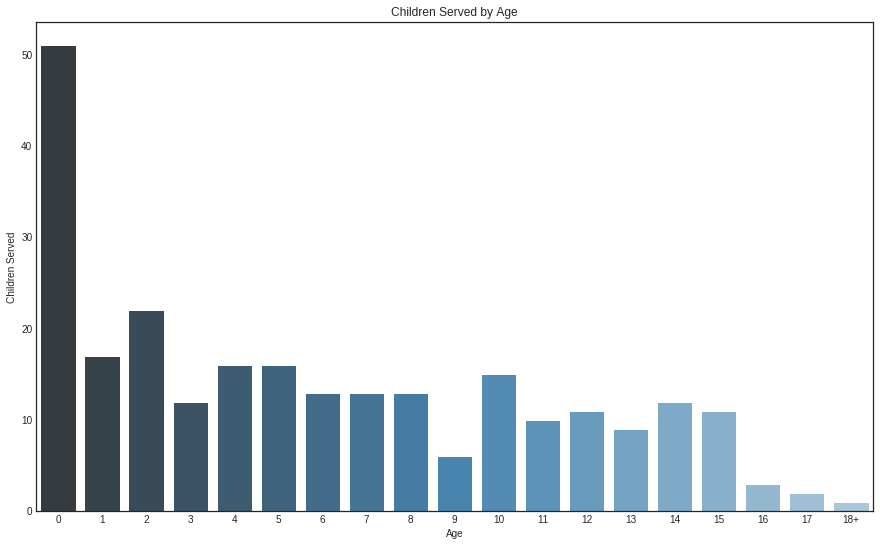

In [183]:
served_by_age()